In [ ]:
!pip install easyocr
!pip install imutils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 16.9 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import imutils
import easyocr
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
import tensorflow as tf
import zipfile
import gdown

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.python.keras.models import Model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, AveragePooling2D, Activation, Add
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Input
from PIL import Image
from matplotlib import pyplot as plt
from keras import backend as K

In [ ]:
# Download Datasheet
url = "https://drive.google.com/uc?id=1joQyCt0MSKcGQd9UP29IjAwwZR0iuae6"
output = "plat.zip"

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1joQyCt0MSKcGQd9UP29IjAwwZR0iuae6
To: /content/plat.zip
100%|██████████| 113M/113M [00:01<00:00, 67.8MB/s]


'plat.zip'

In [ ]:
zip_ref = zipfile.ZipFile('/content/plat.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
#mengekstrak xml file untuk nilai xmin, xmax, ymin dan ymax
import xml.etree.ElementTree as ET
from glob import glob

path = glob('../content/train/*.xml')
labels_dict = {'filepath': [], 'xmin': [], 'xmax': [], 'ymin': [], 'ymax': []}

for filename in path:
    try:
        info = ET.parse(filename)
        root = info.getroot()
        member_object = root.find('object')
        labels_info = member_object.find('bndbox')
        xmin = int(labels_info.find('xmin').text)
        xmax = int(labels_info.find('xmax').text)
        ymin = int(labels_info.find('ymin').text)
        ymax = int(labels_info.find('ymax').text)

        labels_dict['filepath'].append(filename)
        labels_dict['xmin'].append(xmin)
        labels_dict['xmax'].append(xmax)
        labels_dict['ymin'].append(ymin)
        labels_dict['ymax'].append(ymax)
    except (ET.ParseError, AttributeError) as e:
        print(f"Error processing {filename}: {e}")

In [ ]:
#mengekspor nilai xml yang terbaca ke dalam bentuk csv
df = pd.DataFrame(labels_dict)
df.to_csv('nilai_bondbox.csv',index=False)
df.head()

filepath  xmin  xmax  ymin  ymax
0  ../content/train/Cars129_png.rf.ee367c158928e2...   246   340   342   429
1  ../content/train/IMG_20230828_134759_1_jpg.rf....    92   224   433   495
2  ../content/train/IMG_20230506_130804_jpg.rf.84...   237   414   285   357
3  ../content/train/Cars120_png.rf.278f5a6da374d9...   254   399   429   482
4  ../content/train/IMG_20230828_133317_1_jpg.rf....   235   408   410   505

In [ ]:
#mengekstrak nama file dari masing-masing gambar
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('../content/train/',filename_image)
    return filepath_image
getFilename(filename)

'../content/train/Cars129_png.rf.ee367c158928e22464fd7a84f13bebaf.jpg'

In [ ]:
#validasi gambar manual secara acak
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]

['../content/train/Cars129_png.rf.ee367c158928e22464fd7a84f13bebaf.jpg',
 '../content/train/IMG_20230828_134759_1_jpg.rf.4c92cff96d5b0bc5df86824779279939.jpg',
 '../content/train/IMG_20230506_130804_jpg.rf.8445b6ec08c6685cb6e3791d510fb01d.jpg',
 '../content/train/Cars120_png.rf.278f5a6da374d98d2c0cbfef8744403d.jpg',
 '../content/train/IMG_20230828_133317_1_jpg.rf.3a7aa00a22a75eaf145ce173b5ed8428.jpg',
 '../content/train/N235_jpeg.rf.0e7ec0c6530ce792a64844661aeddf77.jpg',
 '../content/train/IMG_20230828_134218_jpg.rf.468b20ab4dc425e0e191ba2f39176593.jpg',
 '../content/train/20230506_171119_jpg.rf.b126d36966ac98b265b1424d95a09cee.jpg',
 '../content/train/IMG_20230911_113440_986_jpg.rf.d6641c96cbf1cdb0b842aea2af94eef5.jpg',
 '../content/train/N190_jpeg.rf.b583e7075a9c2847ae75cebf63b008cc.jpg']

In [ ]:
#validasi antara bondbox dengan gambar secara manual
file_path = image_path[0]
img = cv2.imread(file_path)
img = io.imread(file_path)
fig = px.imshow(img)
fig.update_layout(width=500, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Gambar index ke-0 dengan bondbox')
fig.add_shape(type='rect',x0=168, x1=517, y0=325, y1=495, xref='x', yref='y',line_color='red')

In [ ]:
#Proses preprocessing gambar yang digunakan untuk train model
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = tf.keras.preprocessing.image.load_img(image,target_size=(224,224))
    load_image_arr = tf.keras.preprocessing.image.img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [ ]:
#Melakukan konversi nilai data menjadi array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [ ]:
#Melakukan pembagian dataset menjadi train dan testing
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)

print('shape dari x train :', x_train.shape)
print('shape dari x test :', x_test.shape)
print('shape dari y train :', y_train.shape)
print('shape dari y test :',y_test.shape)

shape dari x train : (1290, 224, 224, 3)
shape dari x test : (323, 224, 224, 3)
shape dari y train : (1290, 4)
shape dari y test : (323, 4)


In [ ]:
#Kustom model VGG16
model = Sequential()

# blok 1
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))

# blok 2
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))

# blok 3
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))

# blok 4
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))

# blok 5
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2)))

#output
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                 

In [ ]:
#Compile model
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_test, y_test)
)

Epoch 1/100
41/41 [==============================] - 5s 113ms/step - loss: 0.1220 - accuracy: 0.9884 - val_loss: 0.1241 - val_accuracy: 0.9381
Epoch 2/100
41/41 [==============================] - 4s 100ms/step - loss: 0.1220 - accuracy: 0.9837 - val_loss: 0.1243 - val_accuracy: 0.9350
Epoch 3/100
41/41 [==============================] - 4s 101ms/step - loss: 0.1220 - accuracy: 0.9876 - val_loss: 0.1242 - val_accuracy: 0.9350
Epoch 4/100
41/41 [==============================] - 4s 100ms/step - loss: 0.1220 - accuracy: 0.9938 - val_loss: 0.1242 - val_accuracy: 0.9505
Epoch 5/100
41/41 [==============================] - 4s 100ms/step - loss: 0.1221 - accuracy: 0.9860 - val_loss: 0.1244 - val_accuracy: 0.9412
Epoch 6/100
41/41 [==============================] - 4s 102ms/step - loss: 0.1220 - accuracy: 0.9891 - val_loss: 0.1242 - val_accuracy: 0.9474
Epoch 7/100
41/41 [==============================] - 4s 99ms/step - loss: 0.1221 - accuracy: 0.9868 - val_loss: 0.1242 - val_accuracy: 0.9443


In [ ]:
# Extracting accuracy and loss values
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Print the final accuracy and loss values
final_train_accuracy = train_accuracy[-1]
final_validation_accuracy = validation_accuracy[-1]

final_train_loss = train_loss[-1]
final_validation_loss = validation_loss[-1]

print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_validation_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_validation_loss:.4f}")

Final Training Accuracy: 0.9891
Final Validation Accuracy: 0.9381
Final Training Loss: 0.1220
Final Validation Loss: 0.1242


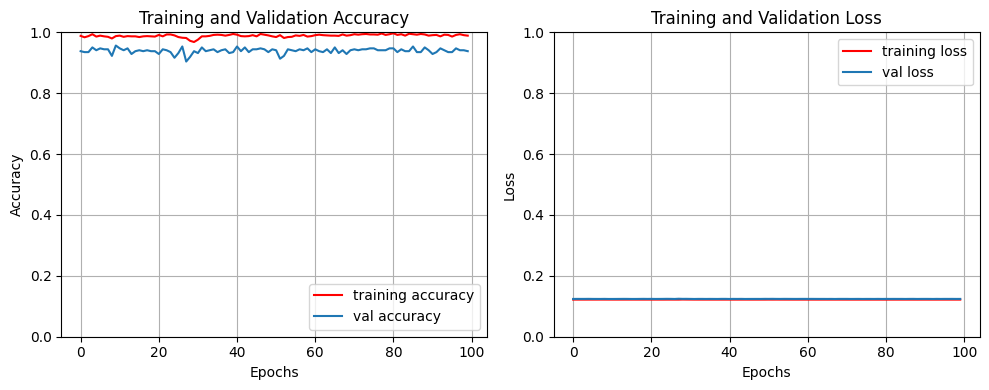

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(100)

# Calculate the maximum value for y-axis (1 in this case)
max_y_value = 1.0

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epoch_range, accuracy, label='training accuracy', color='red')
plt.plot(epoch_range, val_accuracy, label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.ylim([0, max_y_value])

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label='training loss', color='red')
plt.plot(epoch_range, val_loss, label='val loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.ylim([0, max_y_value])

plt.tight_layout()
plt.show()

In [ ]:
#Simpan model
tf.keras.models.save_model(model,'../content/LPR_VGG16_ORI_050124')

In [ ]:
!zip -r /content/LPR_VGG16_ORI_050124.zip /content/LPR_VGG16_ORI_050124/

  adding: content/LPR_VGG16_ORI_050124/ (stored 0%)
  adding: content/LPR_VGG16_ORI_050124/assets/ (stored 0%)
  adding: content/LPR_VGG16_ORI_050124/fingerprint.pb (stored 0%)
  adding: content/LPR_VGG16_ORI_050124/keras_metadata.pb (deflated 94%)
  adding: content/LPR_VGG16_ORI_050124/variables/ (stored 0%)
  adding: content/LPR_VGG16_ORI_050124/variables/variables.index (deflated 72%)
  adding: content/LPR_VGG16_ORI_050124/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: content/LPR_VGG16_ORI_050124/saved_model.pb (deflated 89%)


In [ ]:
from google.colab import files

files.download('/content/LPR_VGG16_ORI_050124.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = tf.keras.models.load_model('../content/LPR_VGG16_050124_Sigmoid')
print('Model loaded Sucessfully')

Model loaded Sucessfully


In [ ]:
path = '../content/IMG_20230506_123219.jpg'
image = tf.keras.preprocessing.image.load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = tf.keras.preprocessing.image.load_img(path,target_size=(256,256))
image_arr_224 = tf.keras.preprocessing.image.img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)

Height of the image = 640
Width of the image = 640


In [ ]:
fig = px.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
fig = px.imshow(image)
fig.update_layout(width=700, height=500,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 13 - TEST Image')

In [ ]:
image_arr_224.shape

(256, 256, 3)

In [ ]:
test_arr = image_arr_224.reshape(1,256,256,3)
test_arr.shape

(1, 256, 256, 3)

In [ ]:
# Make predictions
coords = model.predict(test_arr)
coords

1/1 [==============================] - 1s 959ms/step


array([[0.33740598, 0.6514706 , 0.48052645, 0.5796659 ]], dtype=float32)

In [ ]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[215.93982697, 416.941185  , 307.53692627, 370.98617554]])

In [ ]:
coords = coords.astype(np.int32)
coords

array([[215, 416, 307, 370]], dtype=int32)

In [ ]:
# Draw bounding on top the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(215, 307) (416, 370)


In [ ]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))

In [ ]:
# Create pipeline
path = '../content/WhatsApp Image 2023-08-01 at 06.18.42.jpg'
def object_detection(path):

    # Read image
    image = tf.keras.preprocessing.image.load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = tf.keras.preprocessing.image.load_img(path,target_size=(256,256))

    # Data preprocessing
    image_arr_224 = tf.keras.preprocessing.image.img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,256,256,3)

    # Make predictions
    coords = model.predict(test_arr)

    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)

    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

1/1 [==============================] - 0s 60ms/step
(446, 589) (840, 749)


In [ ]:
img = np.array(tf.keras.preprocessing.image.load_img(path))

# Define the region of interest
xmin, xmax, ymin, ymax = cods[0]
roi = img[ymin:ymax, xmin:xmax]

# Convert the image to grayscale
#gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

# Apply a threshold to the grayscale image
#_, thresh = cv2.threshold(gray, 172, 255, cv2.THRESH_BINARY)

# Apply edge detection to the thresholded image
#edges = cv2.Canny(thresh, 100, 200)

# Convert the edge image to RGB format
#edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

# Display the edges
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 16 Cropped, Thresholded, and Edged Image')
fig.show()

In [ ]:
# extract text from image easyOCR
reader = easyocr.Reader(['en'])
result = reader.readtext(roi, detail=0, paragraph=True)
print(result)

["DK 2799 ADR '27"]


In [ ]:
text = result[0]
font = cv2.FONT_HERSHEY_SIMPLEX
img = cv2.rectangle(img,pt1,pt2,(0,255,0),3)
img = cv2.putText(img,text,pt1, font, 1,(200,200,0),2,cv2.LINE_AA)
fig = px.imshow(img)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))